# Transfer Learning via InceptionV3

In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
%matplotlib inline

/usr/lib/python2.7/dist-packages/skimage/transform/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._hough_transform import (hough_ellipse, hough_line,
/usr/lib/python2.7/dist-packages/skimage/draw/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._draw import (line, line_aa, polygon, ellipse_perimeter,
/usr/lib/python2.7/dist-packages/skimage/measure/_marching_cubes.py:2: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import _marching_cubes_cy
/usr/lib/python2.7/dist-packages/skimage/measure/_label.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._ccomp import label as _label
/usr/lib/python2.7/dist-packages/skimage/morphology/grey.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from . import cmorph
/usr/lib/python2.7/dist-packages/skimage/filter/rank/generic.py:23

In [3]:
TRAIN_DIR = "./train/"
TEST_DIR =  "./test/"

In [4]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['daisy']:
                label = 0
            elif nextdir in ['dandelion']:
                label = 1
            elif nextdir in ['rose']:
                label = 2
            elif nextdir in ['sunflower']:
                label = 3
            else:
                label = 4
    return nextdir, label

**Pre-processing**

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['daisy']:
                label = 0
            elif nextDir in ['dandelion']:
                label = 1
            elif nextDir in ['rose']:
                label = 2
            elif nextDir in ['sunflower']:
                label = 3
            else:
                label = 4
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 522/522 [00:02<00:00, 252.39it/s]


In [8]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 212/212 [00:00<00:00, 219.63it/s]


In [9]:
print(X_train.shape,'\n',X_test.shape)

((3320, 150, 150, 3), '\n', (1003, 150, 150, 3))


In [10]:
print(y_train.shape,'\n',y_test.shape)

((3320,), '\n', (1003,))


In [11]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

Using TensorFlow backend.


In [12]:
daIimages = os.listdir(TRAIN_DIR + "daisy")
Danimages = os.listdir(TRAIN_DIR + "dandelion")

## Plotting the Images.

(Left) - Daisy Vs (Right) - Dandelion
-----------------------------------------------------------------------------------------------------------------------------------


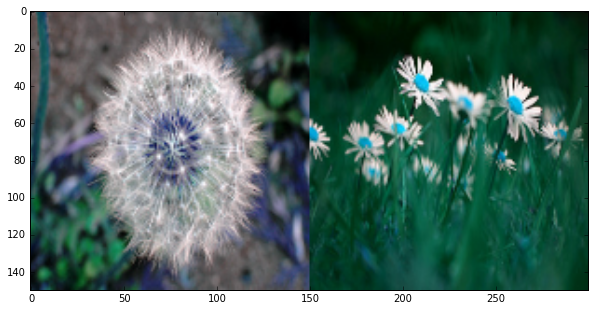

(Left) - Daisy Vs (Right) - Dandelion
-----------------------------------------------------------------------------------------------------------------------------------


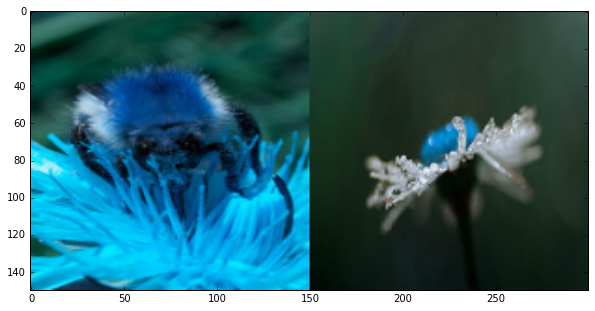

(Left) - Daisy Vs (Right) - Dandelion
-----------------------------------------------------------------------------------------------------------------------------------


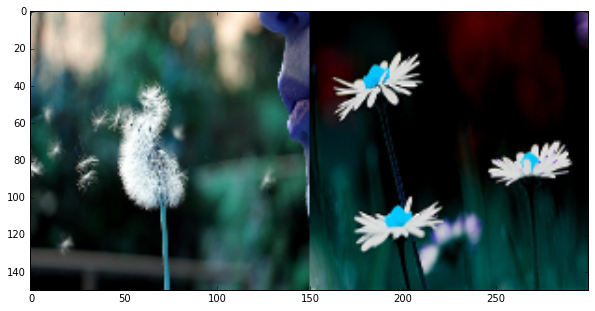

(Left) - Daisy Vs (Right) - Dandelion
-----------------------------------------------------------------------------------------------------------------------------------


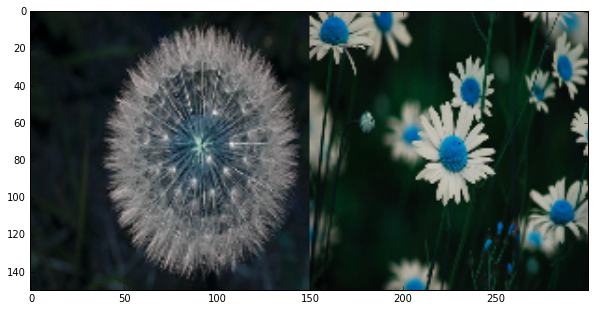

(Left) - Daisy Vs (Right) - Dandelion
-----------------------------------------------------------------------------------------------------------------------------------


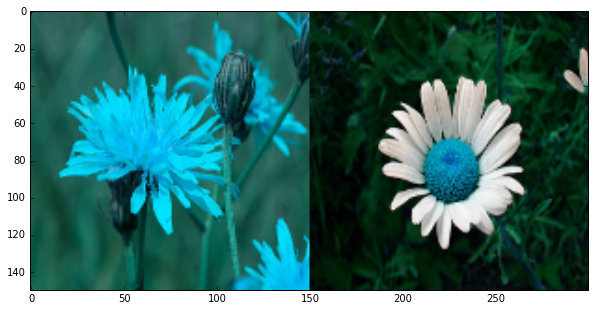

In [13]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"daisy/"+daIimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"dandelion/"+Danimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - Daisy Vs (Right) - Dandelion")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [14]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [15]:
filepath="transferlearning_weights_flowers.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size chan

In [17]:
X_train=X_train.reshape(3320,3,150,150)
X_test=X_test.reshape(1003,3,150,150)

In [18]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

In [19]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

In [20]:
base_model.load_weights("./inception_v3_weights.h5")

In [21]:
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [23]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 150, 150)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 74, 74)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 74, 74)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
batch_size = 120
epochs = 20

In [25]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 3320 samples, validate on 1003 samples
Epoch 1/20
3320/3320 [==============================] - 27s 8ms/step - loss: 1.5291 - acc: 0.3867 - val_loss: 2.8704 - val_acc: 0.4317

Epoch 00001: val_acc improved from -inf to 0.43170, saving model to transferlearning_weights_flowers.hdf5
Epoch 2/20
3320/3320 [==============================] - 13s 4ms/step - loss: 1.2299 - acc: 0.5096 - val_loss: 2.1626 - val_acc: 0.4506

Epoch 00002: val_acc improved from 0.43170 to 0.45065, saving model to transferlearning_weights_flowers.hdf5
Epoch 3/20
3320/3320 [==============================] - 13s 4ms/step - loss: 1.1612 - acc: 0.5346 - val_loss: 1.9396 - val_acc: 0.3380

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000475.

Epoch 00003: val_acc did not improve from 0.45065
Epoch 4/20
3320/3320 [==============================] - 12s 4ms/step - loss: 1.0666 - acc: 0.5807 - val_loss: 1.1631 - val_acc: 0.5563

Epoch 00004: val_acc improved from 0.45065 to 0.55633, saving model

In [26]:
model.load_weights("transferlearning_weights_flowers.hdf5")

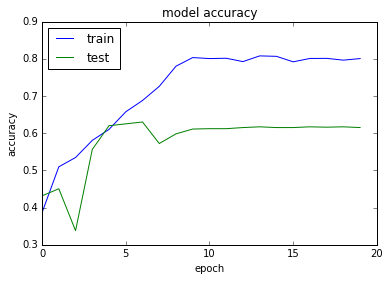

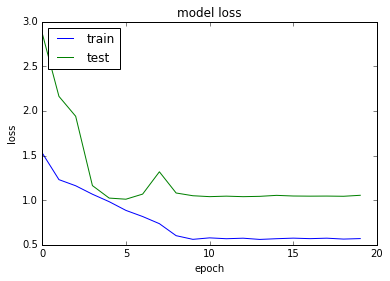

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

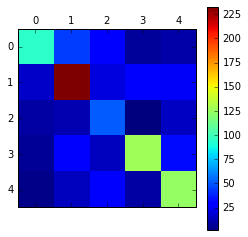

In [29]:
import pylab as pl
CM = confusion_matrix(y_true, pred)
pl.matshow(CM)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

**Notice how the confusion matrix changed from other notebook and became even better than before. **

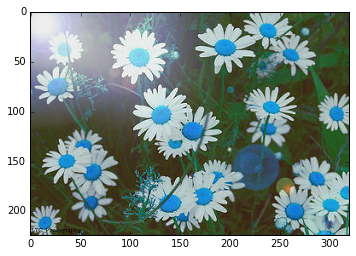

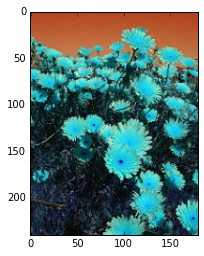

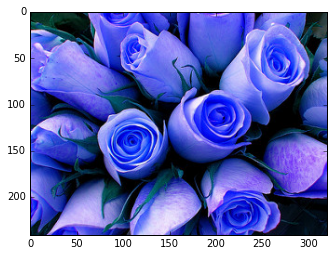

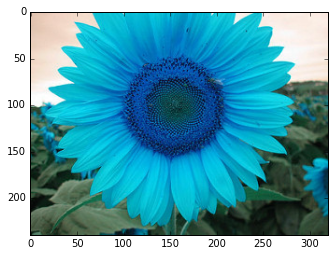

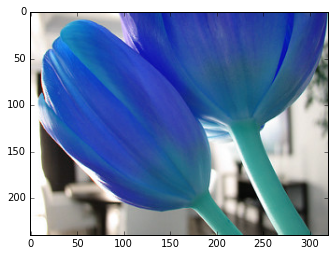

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (3, 150, 150)

In [39]:
#import time
#model_trained = load_model(filepath)
#from keras.preprocessing import image
#start_time = time.time()
from keras.preprocessing import image


img = cv2.imread("/root/CNN/flowers/test/daisy/14551098743_2842e7a004_n.jpg")
#print(type(img))
normaX = skimage.transform.resize(img, (3, 150, 150))
normaX = np.asarray(normaX)

plt.imshow(img)
plt.show()
    
img = cv2.imread("/root/CNN/flowers/test/dandelion/8475758_4c861ab268_m.jpg")
#print(type(img))
normaX1 = skimage.transform.resize(img, (150, 150, 3))
normaX1 = np.asarray(normaX1)

plt.imshow(img)
plt.show()

img = cv2.imread("/root/CNN/flowers/test/rose/118974357_0faa23cce9_n.jpg")
#print(type(img))
normaX2 = skimage.transform.resize(img, (150, 150, 3))
normaX2 = np.asarray(normaX2)

plt.imshow(img)
plt.show()

img = cv2.imread("/root/CNN/flowers/test/sunflower/40410814_fba3837226_n.jpg")
#print(type(img))
normaX3 = skimage.transform.resize(img, (150, 150, 3))
normaX3 = np.asarray(normaX3)

plt.imshow(img)
plt.show()

img = cv2.imread("/root/CNN/flowers/test/tulip/65347450_53658c63bd_n.jpg")
#print(type(img))
normaX4 = skimage.transform.resize(img, (150, 150, 3))
normaX4 = np.asarray(normaX4)

plt.imshow(img)
plt.show()

predicted0 = model.predict(normaX, batch_size=64)
predicted1 = model.predict(normaX1, batch_size=64)
predicted2 = model.predict(normaX2, batch_size=64)
predicted3 = model.predict(normaX3, batch_size=64)
predicted4 = model.predict(normaX4, batch_size=64)

print('good combination is 0 1 2 3 4')
#print('predicted')
#print(predicted)
print('Class predicted')
print(np.argmax(predicted0))
print(np.argmax(predicted1))
print(np.argmax(predicted2))
print(np.argmax(predicted3))
print(np.argmax(predicted4))